In [31]:
import rucio.client
import fsspec
import requests
from utils import get_signed_url, setup_rucio_and_proxy
import aiohttp
import asyncio
import uproot
import time
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from ipywidgets import FileUpload
upload = FileUpload()
display(upload)

FileUpload(value={}, description='Upload')

In [6]:
setup_rucio_and_proxy(upload.data[-1])
rucio_client = rucio.client.Client()

In [7]:
url = get_signed_url(rucio_client, "data17_13TeV", "DAOD_PHYSLITE.22958105._000331.pool.root.1")

In [9]:
%%time
res = requests.get(url, stream=True)
total_size = 0
for chunk in res.iter_content(1024 * 1024):
    total_size += len(chunk)

CPU times: user 798 ms, sys: 835 ms, total: 1.63 s
Wall time: 2.13 s


In [10]:
%%time
bs = 1024 * 1024
with fsspec.open(url, mode="rb", cache_type="readahead", block_size=bs) as f:
    data = f.read(total_size)

CPU times: user 1.63 s, sys: 2.06 s, total: 3.69 s
Wall time: 3.88 s


In [12]:
async def get_chunk(session, seek, n):
    start = seek
    stop = start + n
    async with session.get(url, headers={"Range": f"bytes={start}-{stop - 1}"}) as response:
        return await response.read()

In [13]:
async def get_chunks(n_connections, ranges):
    conn = aiohttp.TCPConnector(limit=n_connections)
    async with aiohttp.ClientSession(connector=conn) as session:
        return await asyncio.gather(*[get_chunk(session, seek, n) for seek, n in sorted(ranges)])

In [14]:
preload_columns = [
    'AnalysisElectronsAuxDyn.DFCommonElectronsLHLooseBL',
    'AnalysisElectronsAuxDyn.DFCommonElectronsLHTight',
    'AnalysisElectronsAuxDyn.eta',
    'AnalysisElectronsAuxDyn.phi',
    'AnalysisElectronsAuxDyn.pt',
    'AnalysisElectronsAuxDyn.ptvarcone20_TightTTVA_pt1000',
    'AnalysisElectronsAuxDyn.topoetcone20',
    'AnalysisElectronsAuxDyn.trackParticleLinks',
    'AnalysisJetsAuxDyn.GhostTrack',
    'AnalysisJetsAuxDyn.Jvt',
    'AnalysisJetsAuxDyn.NumTrkPt500',
    'AnalysisJetsAuxDyn.SumPtTrkPt500',
    'AnalysisJetsAuxDyn.eta',
    'AnalysisJetsAuxDyn.phi',
    'AnalysisJetsAuxDyn.pt',
    'AnalysisMuonsAuxDyn.DFCommonGoodMuon',
    'AnalysisMuonsAuxDyn.combinedTrackParticleLink.m_persIndex',
    'AnalysisMuonsAuxDyn.combinedTrackParticleLink.m_persKey',
    'AnalysisMuonsAuxDyn.eta',
    'AnalysisMuonsAuxDyn.inDetTrackParticleLink.m_persIndex',
    'AnalysisMuonsAuxDyn.inDetTrackParticleLink.m_persKey',
    'AnalysisMuonsAuxDyn.phi',
    'AnalysisMuonsAuxDyn.pt',
    'AnalysisMuonsAuxDyn.ptvarcone30',
    'AnalysisMuonsAuxDyn.topoetcone20',
    'AnalysisMuonsAuxDyn.topoetcone40',
    'CombinedMuonTrackParticlesAuxDyn.phi',
    'CombinedMuonTrackParticlesAuxDyn.qOverP',
    'CombinedMuonTrackParticlesAuxDyn.theta',
    'PrimaryVerticesAuxDyn.trackParticleLinks',
]

In [15]:
def get_ranges(tree, branches):
    ranges = set()
    for branch_name in branches:
        branch = tree[branch_name]
        basket_bytes = branch.member("fBasketBytes")
        basket_seek = branch.member("fBasketSeek")
        ranges.update(list(zip(basket_seek, basket_bytes))[:-1])
    return ranges

In [17]:
uproot_file = uproot.open(url, http_handler=uproot.MultithreadedHTTPSource)

In [19]:
tree = uproot_file["CollectionTree"]

In [20]:
ranges = get_ranges(tree, preload_columns)

In [22]:
times = []
n_list = [5, 10, 50, 100, 500]
for n in n_list:
    print(n)
    t = time.time()
    # note: notebook cells run in an asyncio loop
    res = await get_chunks(n, sorted(ranges))
    times.append(time.time() - t)
    print(times[-1])

5
39.827852964401245
10
24.27333927154541
50
5.711964845657349
100
4.061799764633179
500
4.646911859512329


In [26]:
t_download = time.time()
res = requests.get(url, stream=True)
total_size = 0
data = []
for chunk in res.iter_content(1024 * 1024):
    total_size += len(chunk)
    data.append(chunk)
data = b"".join(data)
t_download = time.time() - t_download

In [27]:
t_download

2.4516408443450928

In [32]:
total_size_ranges = np.array(list(ranges))[:, 1].sum()
total_size_ranges, len(ranges)

(53906194, 6008)

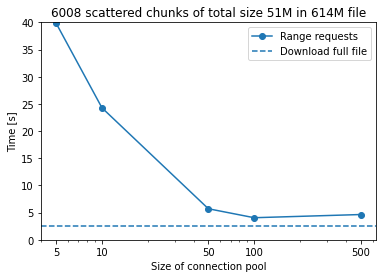

In [33]:
plt.plot(n_list, times, "o-", label="Range requests")
plt.axhline(t_download, linestyle="--", label="Download full file")
plt.ylim(0, 40)
plt.xlabel("Size of connection pool")
plt.ylabel("Time [s]")
plt.xscale("log")
plt.xticks([5, 10, 50, 100, 500], labels=[5, 10, 50, 100, 500])
plt.legend()
plt.title(f"{len(ranges)} scattered chunks of total size {total_size_ranges / 1024 / 1024:.0f}M in {len(data) / 1024 / 1024:.0f}M file")
plt.savefig("range_vs_download.pdf")